In [1]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines import PPO2, A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.evaluation import evaluate_policy

import matplotlib.pyplot as plt

d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

In [2]:
from lutils.stock import LTdxHq
from stockstats import StockDataFrame

In [3]:
ltdxhq = LTdxHq()
df = ltdxhq.get_k_data_1min('603636') # 000032 300142 603636 
# df = ltdxhq.get_k_data_daily('603636')
# df = StockDataFrame(df.rename(columns={'vol': 'volume'}))
# Open,High,Low,Close,Adj Close,Volume
df = df.rename(columns={'open': 'Open', 'close': 'Close', 'high': 'High', 'low': 'Low', 'vol': 'Volume'})
ltdxhq.close()

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,Open,Close,High,Low,Volume,amount
datetime,,,,,,
2021-04-22 09:31:00,10.36,10.41,10.44,10.32,665800.0,6912009.0
2021-04-22 09:32:00,10.41,10.39,10.41,10.37,121900.0,1266145.0
2021-04-22 09:33:00,10.38,10.35,10.39,10.35,81700.0,847631.0
2021-04-22 09:34:00,10.36,10.38,10.39,10.34,176700.0,1832429.0
2021-04-22 09:35:00,10.38,10.43,10.44,10.38,161600.0,1681836.0


In [6]:
# df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

In [7]:
window_size = 10
start_index = window_size
end_index = len(df)

env_maker = lambda: gym.make(
    'stocks-v0',
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

In [8]:
# policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[256, 256, 256], pi=[128, 128])])
model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=10000)

---------------------------------
| explained_variance | -73.9    |
| fps                | 20       |
| nupdates           | 1        |
| policy_entropy     | 0.674    |
| total_timesteps    | 5        |
| value_loss         | 0.00168  |
---------------------------------
---------------------------------
| explained_variance | -0.00925 |
| fps                | 576      |
| nupdates           | 100      |
| policy_entropy     | 0.667    |
| total_timesteps    | 500      |
| value_loss         | 0.000471 |
---------------------------------
---------------------------------
| explained_variance | -0.328   |
| fps                | 665      |
| nupdates           | 200      |
| policy_entropy     | 0.668    |
| total_timesteps    | 1000     |
| value_loss         | 4.05e-05 |
---------------------------------
---------------------------------
| explained_variance | -0.189   |
| fps                | 697      |
| nupdates           | 300      |
| policy_entropy     | 0.672    |
| total_timest

In [9]:
env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 0.699999999999978, 'total_profit': 4.3933174984189666e-36, 'position': 0}


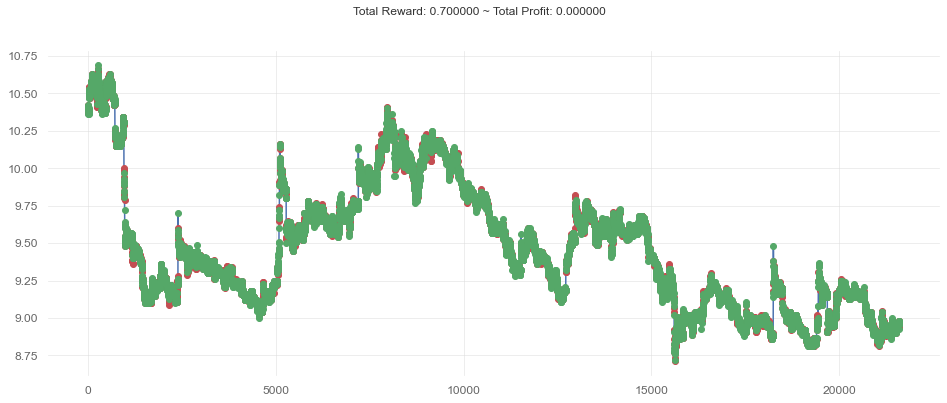

In [10]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2021-04-22
End Period                 2021-08-31
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -100.0%
CAGR%                      -100.0%

Sharpe                     -9.07
Sortino                    -7.88
Sortino/√2                 -5.57

Max Drawdown               -100.0%
Longest DD Days            131
Volatility (ann.)          10.4%
Calmar                     -1.0
Skew                       -1.22
Kurtosis                   -0.36

Expected Daily %           -0.38%
Expected Monthly %         -100.0%
Expected Yearly %          -100.0%
Kelly Criterion            -176.03%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.45%
Expected Shortfall (cVaR)  -1.45%

Gain/Pain Ratio            -1.0
Gain/Pain (1M)             -1.0

Payoff Ratio               0.57
Profit Factor              0.0
Common Sense Ratio         0.0
CPC Index      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-04-22,2021-06-24,2021-08-31,131,-100.0,-100.0


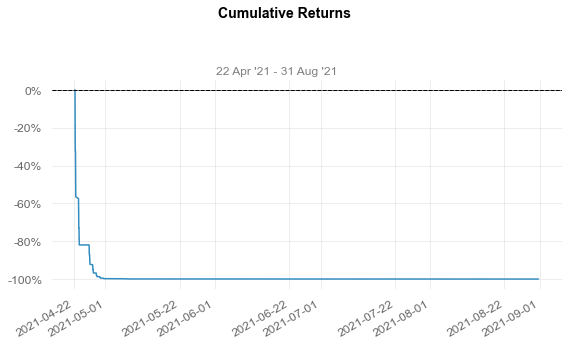

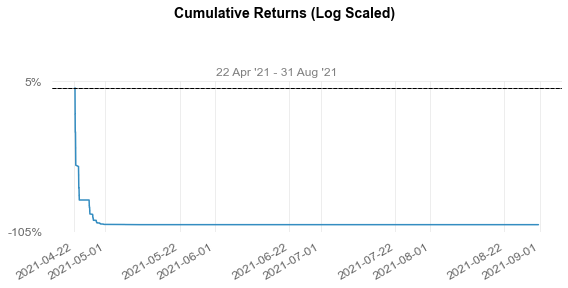

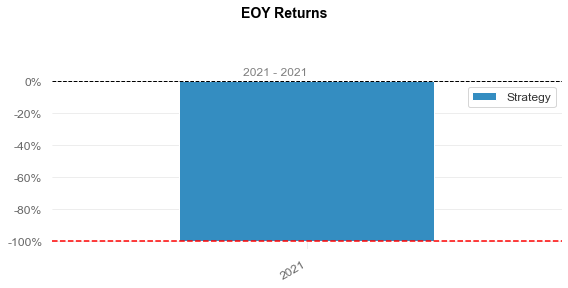

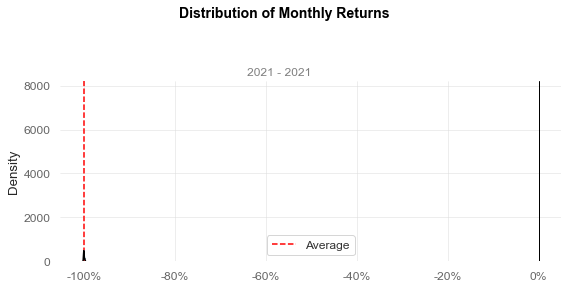

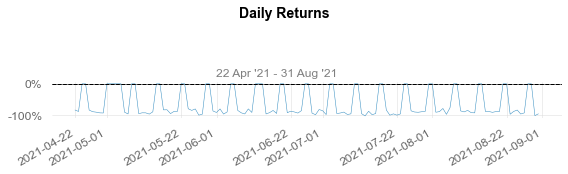

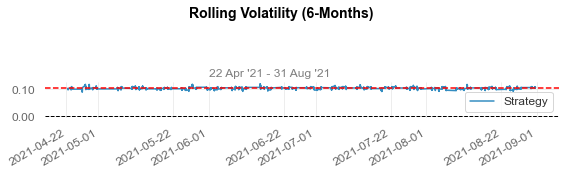

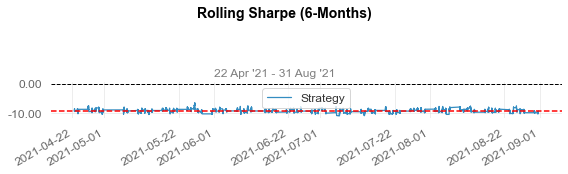

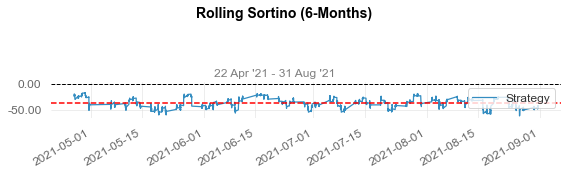

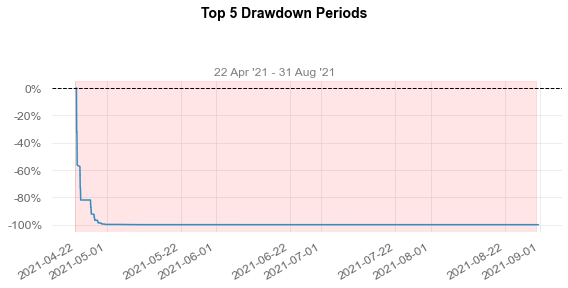

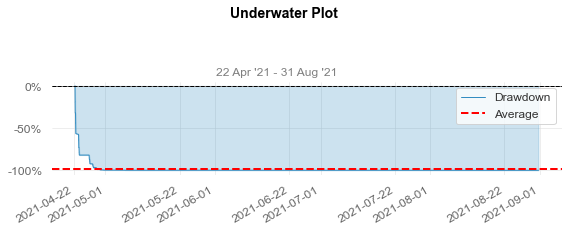

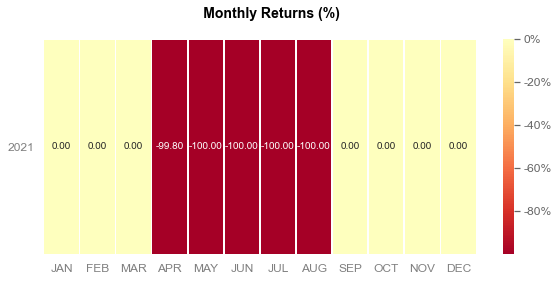

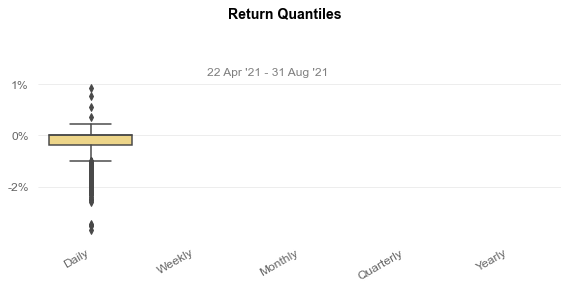

In [12]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
# qs.reports.html(returns, output='a2c_quantstats.html')